In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=[]#2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=[]#2


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display

In [5]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [6]:
all_x = np.load(DATA_DIR / 'starling_128_numpy' / 'all_specs.npy')

In [7]:
x1, x2, x3 = np.load(DATA_DIR / 'starling_128_numpy' / 'j-points.npy')

In [8]:
np.shape(all_x)

(91648, 128, 128)

### PCA

In [9]:
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

In [10]:
# umap
specs_flattened = flatten_spectrograms(all_x)#[:, :10]#[:20000]

In [11]:
np.shape(specs_flattened)

(91648, 16384)

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=1000)

In [14]:
pca.fit(specs_flattened)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
zpca = pca.transform(specs_flattened)

In [16]:
proj = pca.inverse_transform(zpca[0])

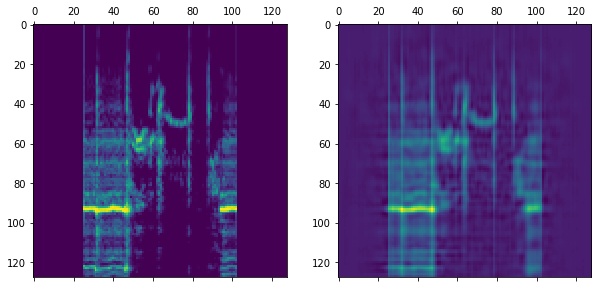

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(specs_flattened[0].reshape((128,128)))
axs[1].matshow(proj.reshape((128,128)))

In [ ]:
np.shape(zpca)

(91648, 1000)

### project umap

In [ ]:
import umap
print(umap.__version__)
#import umap.plot

0.4.0rc1


In [ ]:
N_Z = 10 #128 #works with 2

In [ ]:
mapper = umap.UMAP(random_state=42, n_components=N_Z, verbose=True)
mapper.fit(zpca)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=10, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Fri Mar  6 14:21:06 2020 Finding Nearest Neighbors
Fri Mar  6 14:21:06 2020 Building RP forest with 20 trees
Fri Mar  6 14:21:24 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
Fri Mar  6 14:21:44 2020 Finished Nearest Neighbor Search
Fri Mar  6 14:21:49 2020 Construct embedding
	comp

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=10, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)

In [ ]:
print('test')

In [ ]:
x = mapper.transform(zpca)#.astype('float32'))

### map random points

In [ ]:
#x_r = mapper.inverse_transform(x1)
x_r1 = mapper.inverse_transform(x[:5])

In [ ]:
x_r1 = pca.inverse_transform(x_r1)

In [ ]:
for i in range(5):
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    axs[0].matshow(specs_flattened[i].reshape((128,128)), origin="lower")
    axs[1].matshow(x_r1[i].reshape((128,128)), origin="lower")

In [ ]:
pt1 = x[0]
pt2 = x[1]
pt3 = x[2]

In [ ]:
interp_len = 5

In [ ]:
#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list_pca = mapper.inverse_transform(z_list) 

In [ ]:
x_list = pca.inverse_transform(x_list_pca)

In [ ]:
x_list = x_list.reshape(len(x_list), 128, 128, 1)
np.shape(x_list)

In [ ]:
# make diagram
Jdiagram = np.ones((x_list.shape[1] * (interp_len),
                    x_list.shape[2] * (interp_len + 2), x_list.shape[3]))
np.shape(Jdiagram)

Jdiagram[(interp_len - 1) * x_list.shape[1]:(interp_len) *
         x_list.shape[1], :x_list.shape[2], :] = specs_flattened[2].reshape(
             128, 128, 1)

Jdiagram[(interp_len - 1) * x_list.shape[1]:(interp_len) *
         x_list.shape[1], (interp_len + 1) * x_list.shape[2]:(interp_len + 2) *
         x_list.shape[2], :] = specs_flattened[0].reshape(128, 128, 1)

Jdiagram[:x_list.shape[1], :x_list.shape[2], :] = specs_flattened[1].reshape(
    128, 128, 1)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len - 1 - bi) * x_list.shape[1]:(
            (interp_len - bi)) * x_list.shape[1], (ci + 1) *
                 x_list.shape[2]:(ci + 2) * x_list.shape[2], :] = x_list[i]
        i += 1

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(np.squeeze(Jdiagram), vmin=0, cmap=plt.cm.afmhot, origin='lower')
ax.axis('off')

### map exemplars

In [ ]:
xx = pca.transform(flatten_spectrograms(np.array([x1*255, x2*255, x3*255]).astype('uint8')))

In [ ]:
x_z = mapper.transform(xx)#.astype('float32'))

In [ ]:
plt.scatter(x[:,0], x[:,1], alpha = 0.01, s=1, color='k')
plt.scatter(x_z[:,0], x_z[:,1], alpha = 1, s=30, color = 'red')

In [ ]:
#x_r = mapper.inverse_transform(x1)
x_r = mapper.inverse_transform(x_z)

In [ ]:
x_r = pca.inverse_transform(x_r)

In [ ]:
np.shape(x_r)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(x1[0].reshape((128,128)), origin="lower")
axs[1].matshow(x_r[0].reshape((128,128)), origin="lower")

In [ ]:
np.shape(x_r)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(x2[0].reshape((128,128)), origin="lower")
axs[1].matshow(x_r[1].reshape((128,128)), origin="lower")

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(x3[0].reshape((128,128)), origin="lower")
axs[1].matshow(x_r[2].reshape((128,128)), origin="lower")

In [ ]:
### 2D only
breakme

In [ ]:
corners = np.array([
    [-10, -10],  # 1
    [-10, 10],  # 7
    [10, -10],  # 2
    [10, 10],  # 0
])

test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])


In [ ]:
inv_transformed_points = mapper.inverse_transform(test_pts)

In [ ]:
inv_transformed_points = pca.inverse_transform(inv_transformed_points)

In [ ]:
from matplotlib.gridspec import GridSpec


In [ ]:
# Set up the grid
fig = plt.figure(figsize=(30,15))
gs = GridSpec(10, 20, fig)
scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis
# umap.plot.points(mapper, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], s=1, alpha = 0.05, color='k')
scatter_ax.set(xticks=[], yticks=[])

# Plot the locations of the text points
scatter_ax.scatter(test_pts[:, 0], test_pts[:, 1], c='blue', s=200)
scatter_ax.scatter(x_z[:,0], x_z[:,1], alpha = 1, s=50, color = 'red')

# Plot each of the generated digit images
for i in range(10):
    for j in range(10):
        digit_axes[i, j].imshow(inv_transformed_points[i*10 + j].reshape(128, 128))
        digit_axes[i, j].set(xticks=[], yticks=[])